In [51]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import time
# model trainin set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
#models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
#model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module=r".*sklearn\.utils\.extmath")


In [52]:
import pandas as pd


dfs = []

for i in [5,6,7,8,9]:
    df = pd.read_csv(f"/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/fgraphs/{i}loops.csv")
    df['loops'] = i
    dfs.append(df)

/var/folders/4s/7f5zf8596_526pnhktn077f40000gn/T/ipykernel_41723/1752724830.py:7: DtypeWarning: Columns (127,254,381) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/fgraphs/{i}loops.csv")


In [53]:
dfs = pd.concat(dfs)

In [54]:
# some intra-loop stuff

In [55]:
dfs['Connectivity_is_connected_DEN'] = dfs['Connectivity_is_connected_DEN'].astype(float)
dfs['Connectivity_is_connected_NUM'] = dfs['Connectivity_is_connected_NUM'].astype(float)
dfs['Connectivity_is_connected_TOTAL'] = dfs['Connectivity_is_connected_TOTAL'].astype(float)
dfs['COEFFICIENTS'] = (dfs['COEFFICIENTS'].astype(str).map(eval).map(lambda x: x!= 0)).astype(int)
dfs = dfs.replace(np.inf, np.nan)

(36, 383)
Fold 1 ROC AUC: 1.000
Fold 2 ROC AUC: 1.000
Fold 3 ROC AUC: 0.700
Fold 4 ROC AUC: 0.900
Fold 5 ROC AUC: 1.000

Average ROC AUC: 0.920 ± 0.117


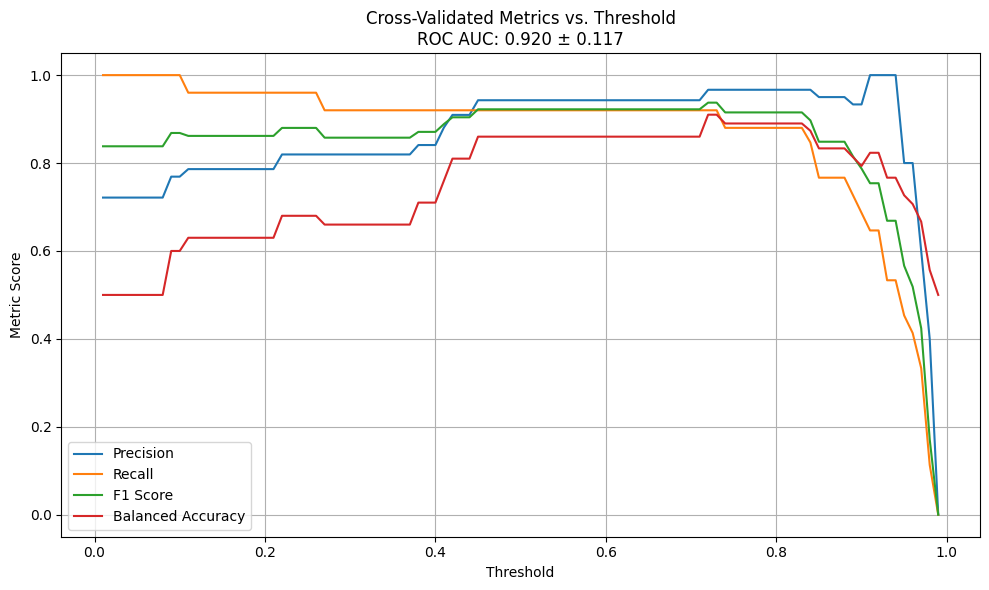

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = dfs[dfs['loops'] == 6]
print(data.shape)
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col and 'loop' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(220, 383)
Fold 1 ROC AUC: 0.853
Fold 2 ROC AUC: 0.882
Fold 3 ROC AUC: 0.796
Fold 4 ROC AUC: 0.813
Fold 5 ROC AUC: 0.920

Average ROC AUC: 0.853 ± 0.045


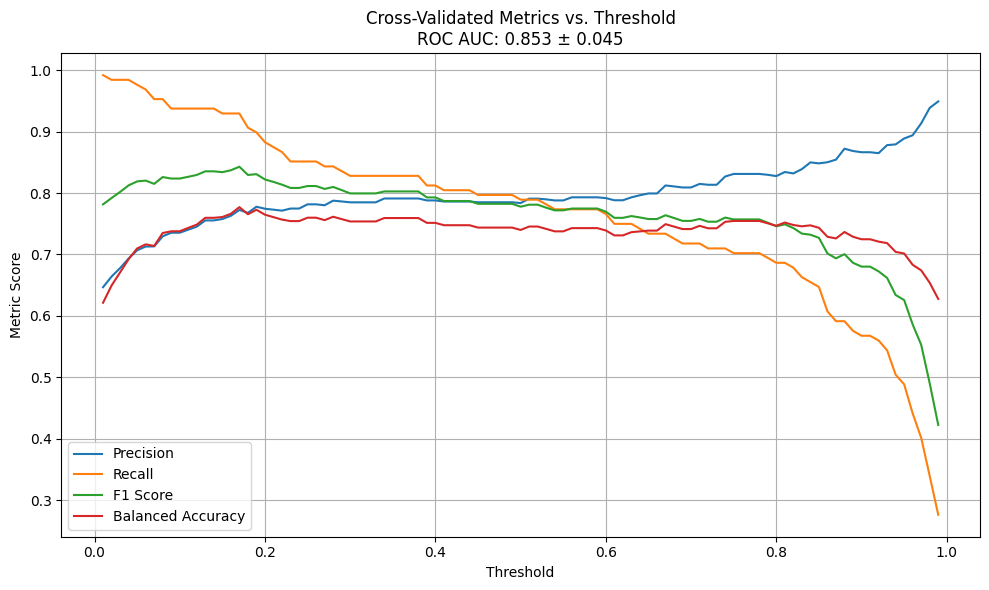

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = dfs[dfs['loops'] == 7]
print(data.shape)
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(2709, 383)
Fold 1 ROC AUC: 0.956
Fold 2 ROC AUC: 0.952
Fold 3 ROC AUC: 0.953
Fold 4 ROC AUC: 0.948
Fold 5 ROC AUC: 0.953

Average ROC AUC: 0.953 ± 0.002


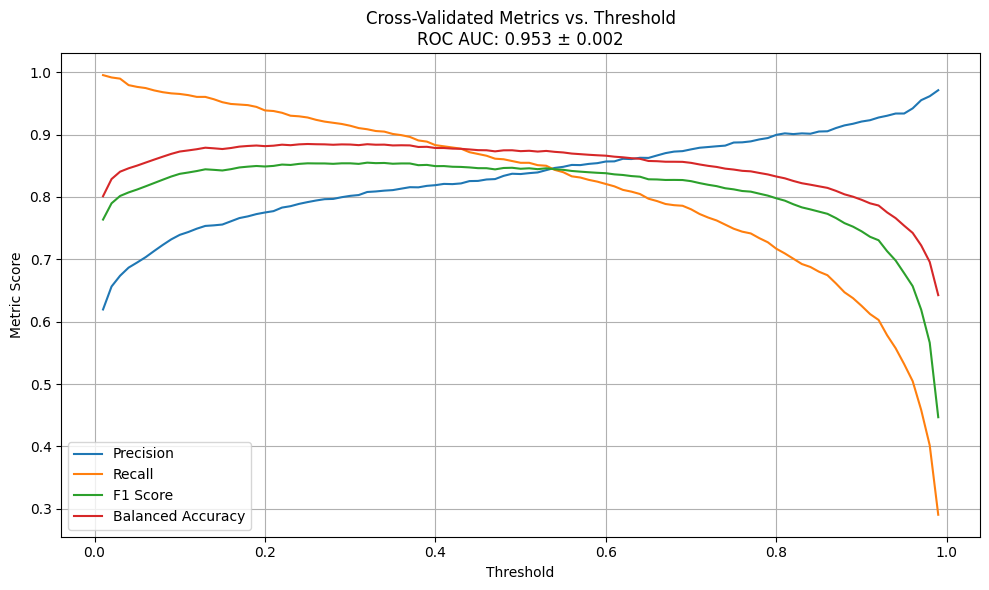

In [59]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = dfs[dfs['loops'] == 8]
print(data.shape)
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(43017, 383)
Fold 1 ROC AUC: 0.968
Fold 2 ROC AUC: 0.970
Fold 3 ROC AUC: 0.967
Fold 4 ROC AUC: 0.970
Fold 5 ROC AUC: 0.967

Average ROC AUC: 0.968 ± 0.001


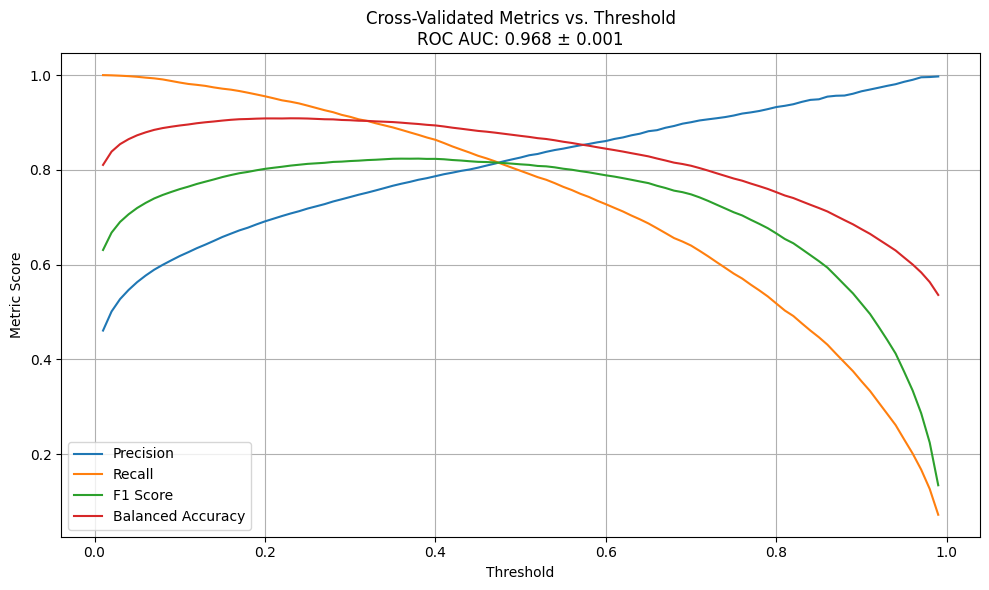

In [60]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = dfs[dfs['loops'] == 9]
print(data.shape)
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
from __future__ import annotations
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Sequence, Dict, Any

def run_cv_threshold_curves(
    df: pd.DataFrame,
    target_col: str = "COEFFICIENTS",
    loop_col: str = "loops",
    loops_to_use: Sequence[int] = (6, 7),           # <- put any loop values here
    n_splits: int = 5,
    thresholds: np.ndarray | None = None,
    model_kwargs: Dict[str, Any] | None = None,
    scale: bool = False,                            # simple toggle; you can wire in StandardScaler if needed
    random_state: int = 42,
):
    """
    Cross-validated evaluation with per-loop ROC AUCs and threshold curves,
    for any set of loop values.

    Assumes binary classification (target in {0,1}).
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    if model_kwargs is None:
        model_kwargs = {}

    # --- filter to requested loops ---
    data = df[df[loop_col].isin(loops_to_use)].copy()
    if data.empty:
        raise ValueError("No rows match the requested loops_to_use.")

    # --- features/target ---
    feature_cols = [c for c in data.columns if c != target_col]
    X = data[feature_cols].to_numpy()
    y = data[target_col].to_numpy().ravel().astype(int)
    loops = data[loop_col].to_numpy()

    # --- stratify by (y, loop) to keep both label and loop balanced across folds ---
    stratify_labels = data[target_col].astype(str) + "_" + data[loop_col].astype(str)

    # --- accumulators for threshold curves (averaged across folds) ---
    thresholds = np.asarray(thresholds, dtype=float)
    precisions = np.zeros_like(thresholds, dtype=float)
    recalls = np.zeros_like(thresholds, dtype=float)
    f1s = np.zeros_like(thresholds, dtype=float)
    balanced_accuracies = np.zeros_like(thresholds, dtype=float)

    # --- per-loop AUCs store ---
    per_loop_aucs: Dict[int, list] = {lv: [] for lv in loops_to_use}

    # --- CV splitter ---
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, stratify_labels), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        loops_test = loops[test_idx]

        # (Optional) scaling hook
        if scale:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # --- model ---
        model = XGBClassifier(eval_metric="logloss", random_state=random_state, **model_kwargs)
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:, 1]

        # --- per-loop AUCs ---
        for lv in loops_to_use:
            mask = (loops_test == lv)
            if mask.any():
                try:
                    auc = roc_auc_score(y_test[mask], y_scores[mask])
                except ValueError:
                    # happens if y has only one class in this subset
                    auc = np.nan
                per_loop_aucs[lv].append(auc)
                print(f"Fold {fold} ROC AUC (loop {lv}): {auc:.3f}" if auc == auc else
                      f"Fold {fold} ROC AUC (loop {lv}): NaN (single-class subset)")
            else:
                print(f"Fold {fold} has no samples for loop {lv}")

        # --- threshold-dependent metrics ---
        for i, t in enumerate(thresholds):
            y_pred = (y_scores >= t).astype(int)
            precisions[i] += precision_score(y_test, y_pred, zero_division=0)
            recalls[i] += recall_score(y_test, y_pred, zero_division=0)
            f1s[i] += f1_score(y_test, y_pred, zero_division=0)
            balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

    # --- average across folds ---
    precisions /= n_splits
    recalls /= n_splits
    f1s /= n_splits
    balanced_accuracies /= n_splits

    # --- print summary AUCs ---
    print("\nAverage ROC AUC by loop:")
    for lv in loops_to_use:
        vals = np.array(per_loop_aucs[lv], dtype=float)
        mean = np.nanmean(vals) if vals.size else np.nan
        std = np.nanstd(vals) if vals.size else np.nan
        print(f"  loop {lv}: {mean:.3f} ± {std:.3f}")

    # --- plot ---
    title_loops = ", ".join(map(str, loops_to_use))
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    plt.title(f"Cross-Validated Metrics vs. Threshold (Loops: {title_loops})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "thresholds": thresholds,
        "precision": precisions,
        "recall": recalls,
        "f1": f1s,
        "balanced_accuracy": balanced_accuracies,
        "per_loop_aucs": per_loop_aucs,
    }

# ---------------- Example usage ----------------
# results = run_cv_threshold_curves(
#     df=dfs,
#     target_col="COEFFICIENTS",
#     loop_col="loops",
#     loops_to_use=[6, 7],          # put any values here, e.g. [10, 11] or [2, 4, 6]
#     n_splits=5,
#     model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
#     scale=False,
# )


Fold 1 ROC AUC (loop 6): 1.000
Fold 1 ROC AUC (loop 7): 0.905
Fold 2 ROC AUC (loop 6): 1.000
Fold 2 ROC AUC (loop 7): 0.848
Fold 3 ROC AUC (loop 6): 1.000
Fold 3 ROC AUC (loop 7): 0.976
Fold 4 ROC AUC (loop 6): 1.000
Fold 4 ROC AUC (loop 7): 0.857
Fold 5 ROC AUC (loop 6): 1.000
Fold 5 ROC AUC (loop 7): 0.857

Average ROC AUC by loop:
  loop 6: 1.000 ± 0.000
  loop 7: 0.889 ± 0.048


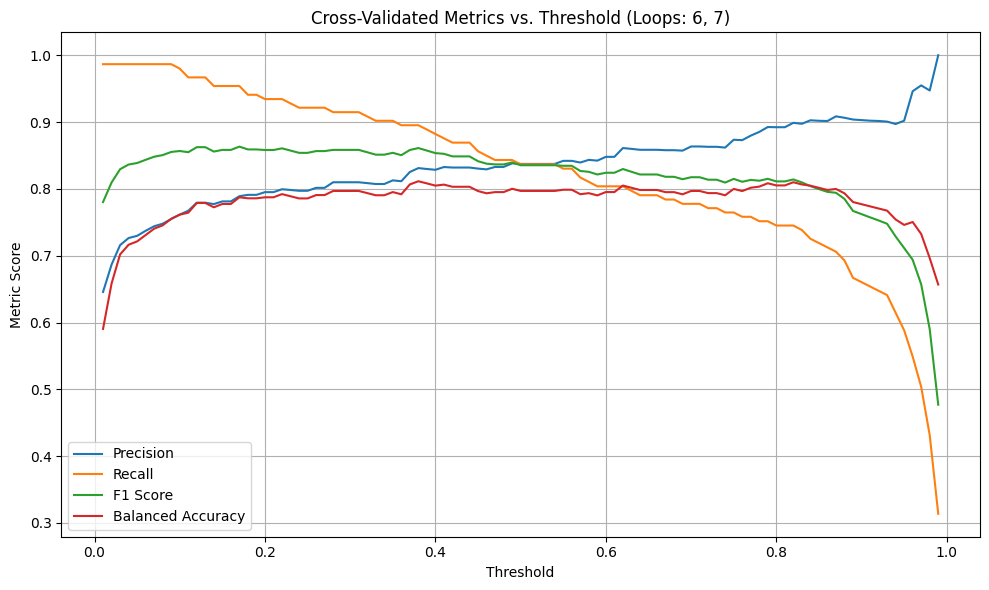

In [70]:

results = run_cv_threshold_curves(
    df=dfs,
    target_col="COEFFICIENTS",
    loop_col="loops",
    loops_to_use=[6,7],          
    n_splits=5,
    model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
    scale=False,
)


Fold 1 ROC AUC (loop 7): 0.912
Fold 1 ROC AUC (loop 8): 0.947
Fold 2 ROC AUC (loop 7): 0.970
Fold 2 ROC AUC (loop 8): 0.956
Fold 3 ROC AUC (loop 7): 0.968
Fold 3 ROC AUC (loop 8): 0.954
Fold 4 ROC AUC (loop 7): 0.903
Fold 4 ROC AUC (loop 8): 0.949
Fold 5 ROC AUC (loop 7): 0.992
Fold 5 ROC AUC (loop 8): 0.963

Average ROC AUC by loop:
  loop 7: 0.949 ± 0.035
  loop 8: 0.954 ± 0.006


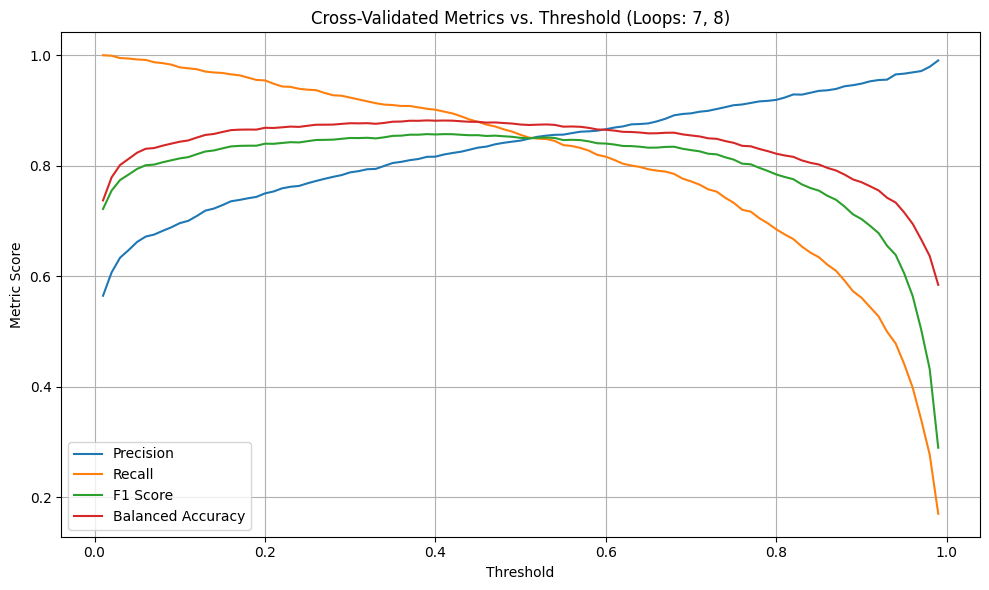

In [71]:

results = run_cv_threshold_curves(
    df=dfs,
    target_col="COEFFICIENTS",
    loop_col="loops",
    loops_to_use=[7,8],          
    n_splits=5,
    model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
    scale=False,
)


Fold 1 ROC AUC (loop 8): 0.975
Fold 1 ROC AUC (loop 9): 0.968
Fold 2 ROC AUC (loop 8): 0.979
Fold 2 ROC AUC (loop 9): 0.970
Fold 3 ROC AUC (loop 8): 0.973
Fold 3 ROC AUC (loop 9): 0.966
Fold 4 ROC AUC (loop 8): 0.968
Fold 4 ROC AUC (loop 9): 0.966
Fold 5 ROC AUC (loop 8): 0.971
Fold 5 ROC AUC (loop 9): 0.969

Average ROC AUC by loop:
  loop 8: 0.973 ± 0.004
  loop 9: 0.968 ± 0.002


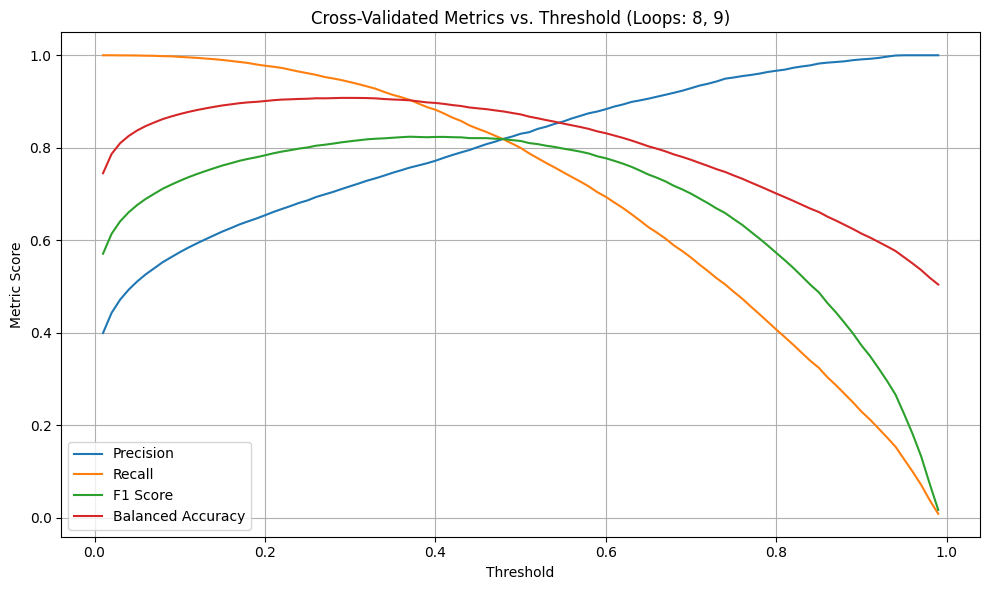

In [72]:
results = run_cv_threshold_curves(
    df=dfs,
    target_col="COEFFICIENTS",
    loop_col="loops",
    loops_to_use=[8,9],          
    n_splits=5,
    model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
    scale=False,
)

Fold 1 ROC AUC (loop 6): 1.000
Fold 1 ROC AUC (loop 9): 0.969
Fold 2 ROC AUC (loop 6): 1.000
Fold 2 ROC AUC (loop 9): 0.969
Fold 3 ROC AUC (loop 6): 1.000
Fold 3 ROC AUC (loop 9): 0.965
Fold 4 ROC AUC (loop 6): 1.000
Fold 4 ROC AUC (loop 9): 0.965
Fold 5 ROC AUC (loop 6): 1.000
Fold 5 ROC AUC (loop 9): 0.969

Average ROC AUC by loop:
  loop 6: 1.000 ± 0.000
  loop 9: 0.967 ± 0.002


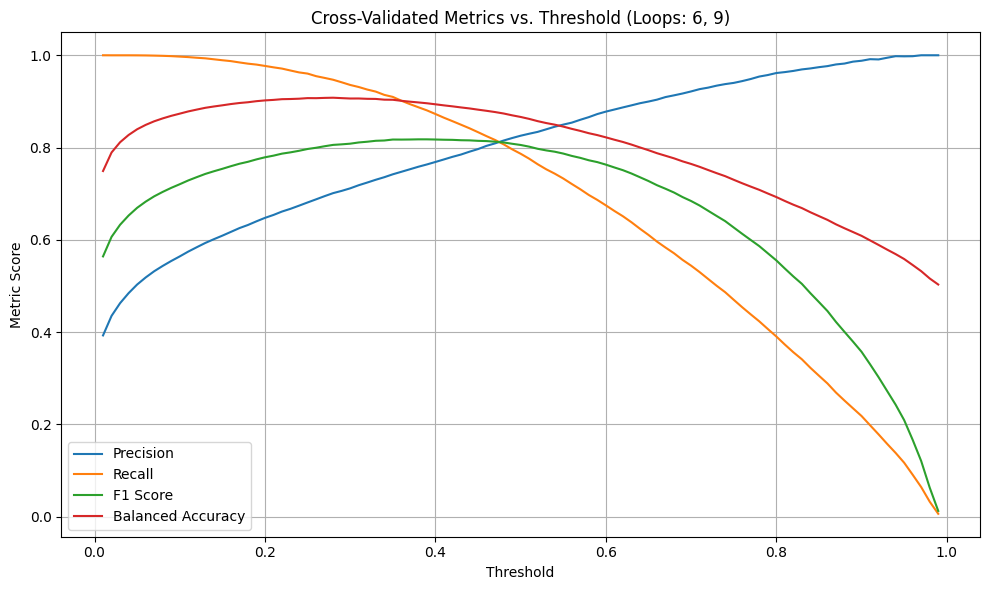

In [74]:
results = run_cv_threshold_curves(
    df=dfs,
    target_col="COEFFICIENTS",
    loop_col="loops",
    loops_to_use=[6,9],          
    n_splits=5,
    model_kwargs=dict(n_estimators=300, max_depth=6, learning_rate=0.05),
    scale=False,
)

In [75]:
# directionality

In [77]:
from __future__ import annotations
from typing import Sequence, Dict, Any, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier


def train_test_loops_eval(
    df: pd.DataFrame,
    *,
    target_col: str = "COEFFICIENTS",
    loop_col: str = "loops",
    train_loops: Sequence[int] = (7,),
    test_loops: Sequence[int] = (8, 9, 10),
    feature_cols: Optional[Sequence[str]] = None,   # if None -> all except target/loop
    thresholds: Optional[np.ndarray] = None,        # if None -> linspace(0.01,0.99,99)
    model_kwargs: Optional[Dict[str, Any]] = None,  # passed to XGBClassifier
    random_state: int = 42,
    save_path: Optional[str] = None,                # path to save PNG; if None, don't save
):
    """
    Trains on rows with loop in train_loops, tests on rows with loop in test_loops.
    Reports per-loop ROC AUC on the test set and draws threshold curves on the *combined* test set.
    Works for any sizes of train/test loop sets.
    """
    if model_kwargs is None:
        model_kwargs = {}
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    # --- split data ---
    train_data = df[df[loop_col].isin(train_loops)].copy()
    test_data  = df[df[loop_col].isin(test_loops)].copy()
    if train_data.empty:
        raise ValueError("No rows match train_loops.")
    if test_data.empty:
        raise ValueError("No rows match test_loops.")

    # --- features ---
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in (target_col, loop_col)]

    X_train = train_data[feature_cols].to_numpy()
    y_train = train_data[target_col].to_numpy().ravel().astype(int)

    X_test  = test_data[feature_cols].to_numpy()
    y_test  = test_data[target_col].to_numpy().ravel().astype(int)
    loop_test = test_data[loop_col].to_numpy()

    # --- model ---
    model = XGBClassifier(eval_metric="logloss", random_state=random_state, **model_kwargs)
    model.fit(X_train, y_train)

    # --- scores ---
    test_scores = model.predict_proba(X_test)[:, 1]

    # per-test-loop AUCs
    per_loop_auc: Dict[int, float] = {}
    for loop_id in test_loops:
        mask = (loop_test == loop_id)
        if mask.any():
            y_true = y_test[mask]
            y_sc   = test_scores[mask]
            try:
                per_loop_auc[loop_id] = roc_auc_score(y_true, y_sc)
                print(f"AUC (loop {loop_id}): {per_loop_auc[loop_id]:.3f}")
            except ValueError:
                # happens if the subset has only one class
                per_loop_auc[loop_id] = np.nan
                print(f"AUC (loop {loop_id}): NaN (single-class subset)")
        else:
            print(f"No samples for loop {loop_id} in test set")

    # (optional) AUC on the training data for reference
    train_scores = model.predict_proba(X_train)[:, 1]
    try:
        train_auc = roc_auc_score(y_train, train_scores)
    except ValueError:
        train_auc = np.nan
    print(f"AUC (train loops {list(train_loops)}): {train_auc:.3f}" if train_auc == train_auc
          else f"AUC (train loops {list(train_loops)}): NaN (single-class)")

    # --- threshold sweep on combined test set ---
    thresholds = np.asarray(thresholds, dtype=float)
    precisions, recalls, f1s, bals = [], [], [], []
    for t in thresholds:
        y_pred = (test_scores >= t).astype(int)
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))
        bals.append(balanced_accuracy_score(y_test, y_pred))
    precisions = np.asarray(precisions)
    recalls    = np.asarray(recalls)
    f1s        = np.asarray(f1s)
    bals       = np.asarray(bals)

    # --- summary print ---
    print("\nSummary:")
    print(f"  Train AUC (loops {list(train_loops)}): {train_auc:.3f}" if train_auc == train_auc
          else f"  Train AUC (loops {list(train_loops)}): NaN (single-class)")
    for loop_id in test_loops:
        if loop_id in per_loop_auc:
            auc_val = per_loop_auc[loop_id]
            print(f"  Test AUC (loop {loop_id}): {auc_val:.3f}" if auc_val == auc_val
                  else f"  Test AUC (loop {loop_id}): NaN (single-class)")

    # --- plot ---
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.plot(thresholds, bals, label="Balanced Accuracy")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    plt.title(f"Train Loops: {list(train_loops)} | Test Loops: {list(test_loops)}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"Saved plot to: {save_path}")
    plt.show()

    return {
        "model": model,
        "feature_cols": list(feature_cols),
        "thresholds": thresholds,
        "precision": precisions,
        "recall": recalls,
        "f1": f1s,
        "balanced_accuracy": bals,
        "per_loop_auc": per_loop_auc,
        "train_auc": train_auc,
    }





AUC (loop 7): 0.836
AUC (train loops [6]): 1.000

Summary:
  Train AUC (loops [6]): 1.000
  Test AUC (loop 7): 0.836
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/6_7.png


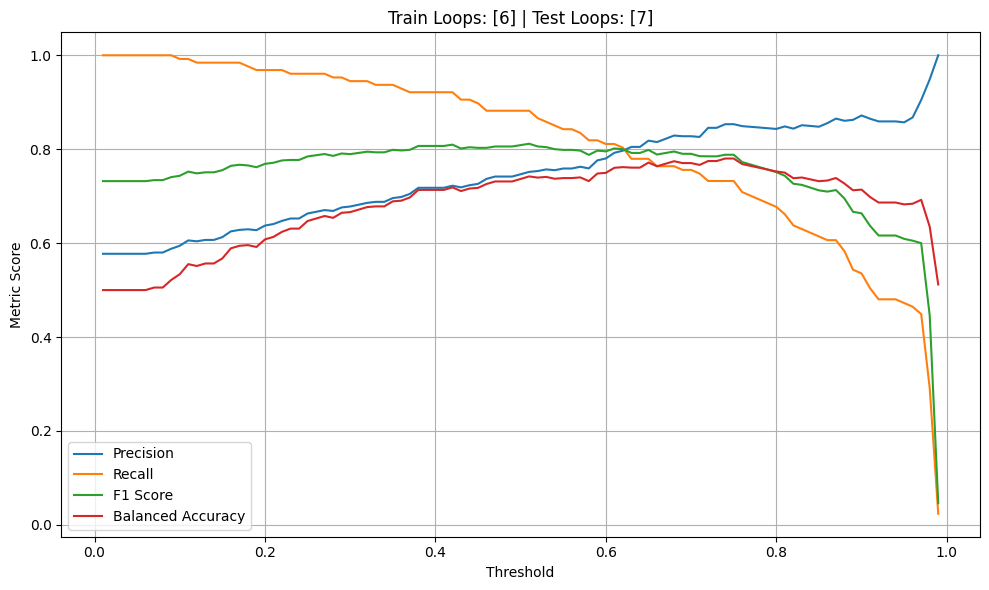

In [79]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[6],            # put ANY train loops here
    test_loops=[7],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/6_7.png",
)

AUC (loop 7): 0.842
AUC (loop 8): 0.725
AUC (loop 9): 0.707
AUC (train loops [5, 6]): 1.000

Summary:
  Train AUC (loops [5, 6]): 1.000
  Test AUC (loop 7): 0.842
  Test AUC (loop 8): 0.725
  Test AUC (loop 9): 0.707
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/56_789.png


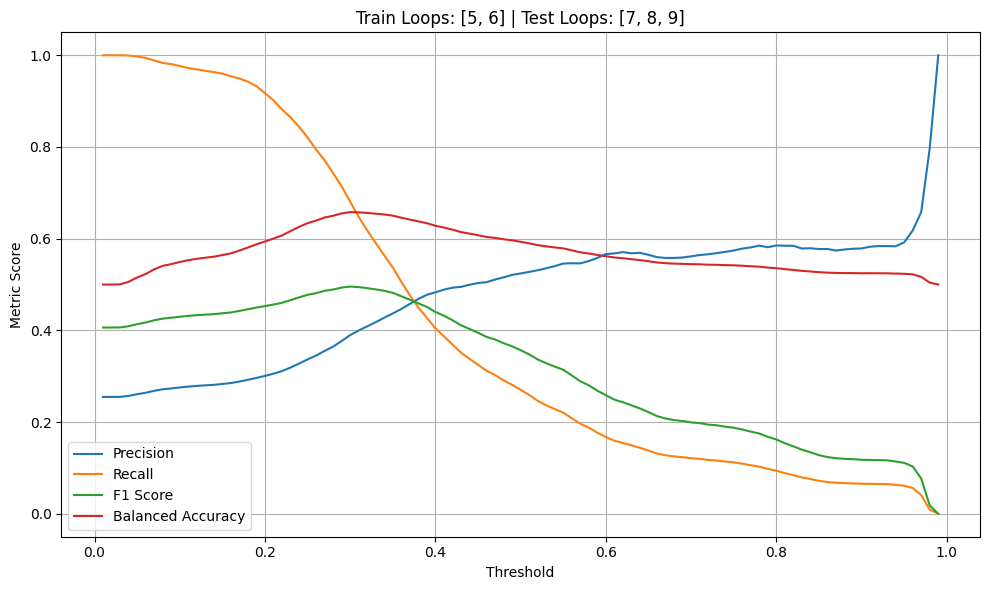

In [80]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[5, 6],            # put ANY train loops here
    test_loops=[7,8, 9],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/56_789.png",
)

AUC (loop 8): 0.872
AUC (loop 9): 0.820
AUC (train loops [5, 6, 7]): 1.000

Summary:
  Train AUC (loops [5, 6, 7]): 1.000
  Test AUC (loop 8): 0.872
  Test AUC (loop 9): 0.820
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/567_89.png


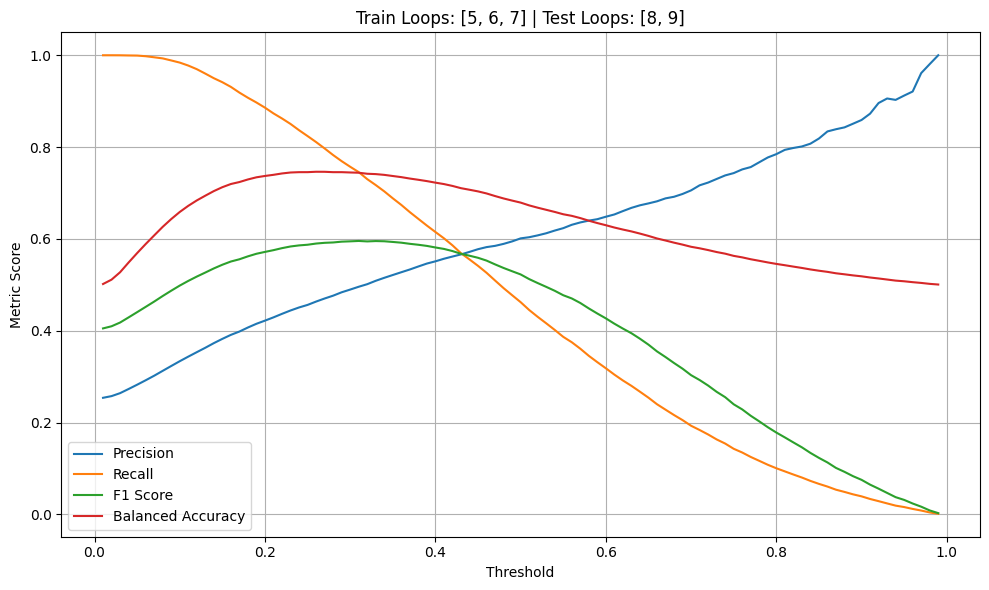

In [81]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[5, 6, 7],            # put ANY train loops here
    test_loops=[8, 9],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/567_89.png",
)

AUC (loop 9): 0.910
AUC (train loops [5, 6, 7, 8]): 1.000

Summary:
  Train AUC (loops [5, 6, 7, 8]): 1.000
  Test AUC (loop 9): 0.910
Saved plot to: /Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/5678_9.png


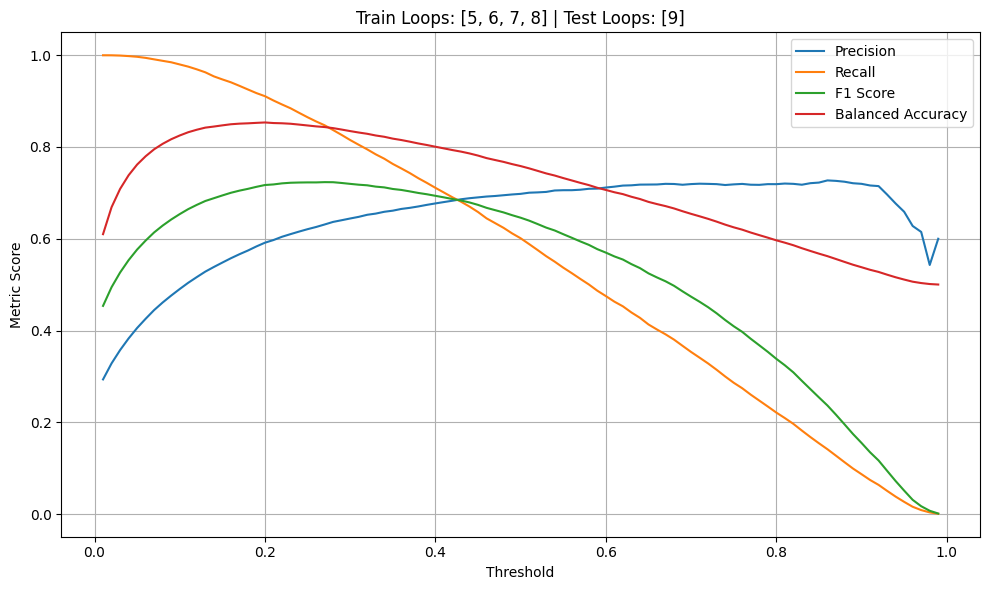

In [82]:

results = train_test_loops_eval(
    df=dfs,
     target_col="COEFFICIENTS",
    loop_col="loops",
    train_loops=[5, 6, 7, 8],            # put ANY train loops here
    test_loops=[9],      # put ANY test loops here
    feature_cols=None,          # or an explicit list
    thresholds=np.linspace(0.01, 0.99, 99),
    model_kwargs=dict(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
    random_state=42,
    save_path="/Users/rezadoobary/Documents/MLCorrelator2/ML-correlator/Tree_classifier_for_graphs/new_stuff/assets/fgraphs/5678_9.png",
)

In [ ]:
##### STOP HERE

In [20]:
##### STOP HERE

In [21]:
# cluster the data and let's see what preditive power we get

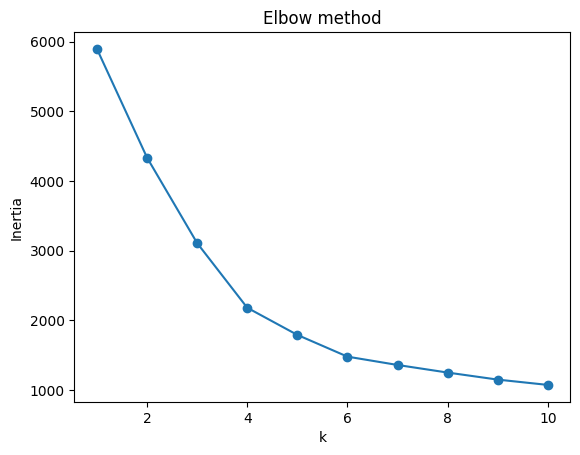

Suggested k = 4


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 7]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


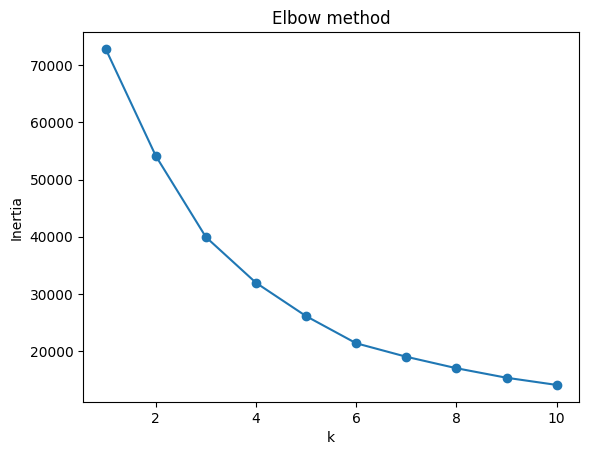

Suggested k = 3


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 8]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


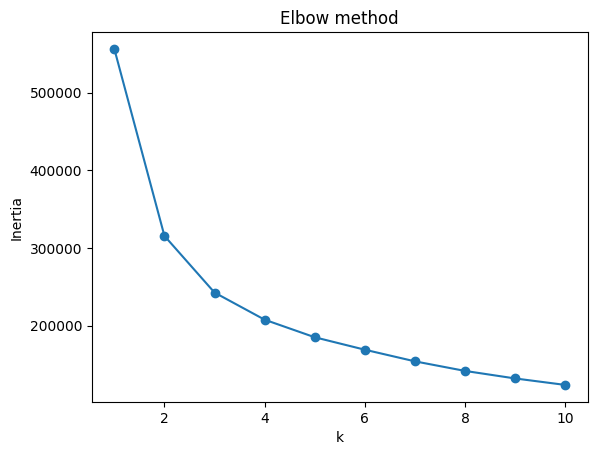

Suggested k = 2


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 9]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


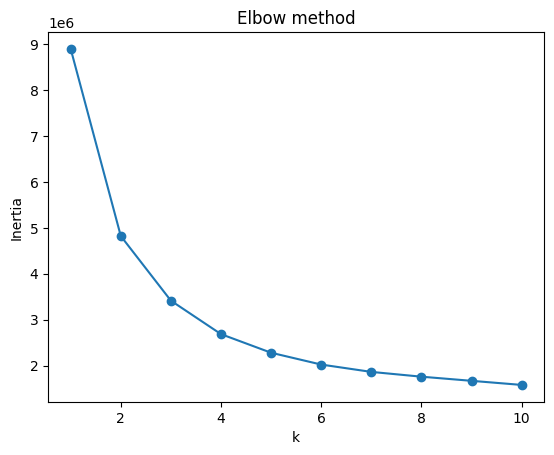

Suggested k = 2


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

loop7 = all_loops[all_loops['loops'] == 10]
loop7 = loop7.dropna(axis = 1)
data_cols = [col for col in loop7.columns if 'COEFFICIENTS' not in col]
X = loop7[data_cols]

inertias = []
for k in range(1, 11):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10)
                    .fit(X).inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow method"); plt.show()

second_deriv = np.diff(inertias, 2)
elbow_k = np.argmax(second_deriv) + 2
print("Suggested k =", elbow_k)

kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)


In [26]:
# let's take 20

In [62]:
"""
Goal
----
Find which cluster (from the ten test loops) you should add to the
training data to maximise performance on the rest of the test set.
"""

import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# ------------------------------------------------------------
# USER SETTINGS
# ------------------------------------------------------------
train_loops  = [7, 8, 9]          # original train loops
test_loops   = list(range(1, 11)) # ten loops → will be clustered
random_state = 42
n_splits     = 5
n_clusters   = 20                 # exactly 10 clusters on the test set
# ------------------------------------------------------------

# ------------------  split data -----------------------------
train_df = all_loops[all_loops["loops"].isin(train_loops)].reset_index(drop=True)
test_df  = all_loops[all_loops["loops"].isin(test_loops )].reset_index(drop=True)

feature_cols = [c for c in all_loops.columns if c not in ("COEFFICIENTS", "loops")]
target_col   = "COEFFICIENTS"

X_train_base = train_df[feature_cols].values
y_train_base = train_df[target_col].values.ravel()

X_test_df    = test_df[feature_cols].copy()      # keep NaNs for XGB
y_test_full  = test_df[target_col].values.ravel()
loops_full   = test_df["loops"].values

# ------------------  cluster test set ----------------------
X_cluster = X_test_df.dropna(axis=1).values      # drop NaN columns for KMeans
kmeans    = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
clusters  = kmeans.fit_predict(X_cluster)

# ------------------  function: train & score ---------------
def train_and_score(X_train, y_train, X_test, y_test):
    """
    Train a fresh XGB (single fit, no CV) and return ROC-AUC on X_test.
    """
    model = XGBClassifier(eval_metric="logloss", random_state=random_state)
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)[:, 1]
    auc  = roc_auc_score(y_test, prob)
    return auc, prob

# ---------- main experiment (unchanged except for bookkeeping) ----------
results = []

for cl in range(n_clusters):
    in_clust  = clusters == cl
    out_clust = ~in_clust

    X_train = np.vstack([X_train_base, X_test_df[in_clust].values])
    y_train = np.concatenate([y_train_base, y_test_full[in_clust]])

    X_test  = X_test_df[out_clust].values
    y_test  = y_test_full[out_clust]
    loops   = loops_full[out_clust]

    auc, prob = train_and_score(X_train, y_train, X_test, y_test)

    results.append(
        dict(cluster=cl,
             added_rows=in_clust.sum(),
             remaining_rows=out_clust.sum(),
             final_train_rows=X_train.shape[0],
             final_test_rows=X_test.shape[0],
             overall_auc=auc,
             auc_by_loop={
                 lp: roc_auc_score(y_test[loops == lp], prob[loops == lp])
                 for lp in np.unique(loops)
             })
    )

# ------------------  report -------------------------------
print("\n=== PROMOTE-ONE-CLUSTER RESULTS ===")
for r in results:
    print(f"Cluster {r['cluster']:2d} | "
          f"rows→train {r['added_rows']:5d} | "
          f"remaining test {r['remaining_rows']:5d} | "
          f"AUC = {r['overall_auc']:.3f}")

best = max(results, key=lambda r: r["overall_auc"])

print(f"\n>>> Add cluster {best['cluster']} "
      f"→ best AUC {best['overall_auc']:.3f}")
print(f"Final TRAIN size = {best['final_train_rows']} rows")
print(f"Final TEST  size = {best['final_test_rows']} rows")

print("\nPer-loop AUC after adding that cluster:")
for lp, score in sorted(best["auc_by_loop"].items()):
    print(f"  Loop {lp:2d} · AUC = {score:.3f}")


=== PROMOTE-ONE-CLUSTER RESULTS ===
Cluster  0 | rows→train 21310 | remaining test 147510 | AUC = 0.889
Cluster  1 | rows→train  4927 | remaining test 163893 | AUC = 0.831
Cluster  2 | rows→train 12960 | remaining test 155860 | AUC = 0.864
Cluster  3 | rows→train  2294 | remaining test 166526 | AUC = 0.850
Cluster  4 | rows→train  1424 | remaining test 167396 | AUC = 0.852
Cluster  5 | rows→train 15156 | remaining test 153664 | AUC = 0.890
Cluster  6 | rows→train  2467 | remaining test 166353 | AUC = 0.849
Cluster  7 | rows→train 16574 | remaining test 152246 | AUC = 0.878
Cluster  8 | rows→train 21277 | remaining test 147543 | AUC = 0.890
Cluster  9 | rows→train   143 | remaining test 168677 | AUC = 0.834
Cluster 10 | rows→train  6077 | remaining test 162743 | AUC = 0.838
Cluster 11 | rows→train   654 | remaining test 168166 | AUC = 0.828
Cluster 12 | rows→train  2600 | remaining test 166220 | AUC = 0.871
Cluster 13 | rows→train  6539 | remaining test 162281 | AUC = 0.830
Cluster 14 

In [63]:
# ------------------------------------------------------------
# 1️⃣  First pass (unchanged) – pick the single best cluster
# ------------------------------------------------------------
first_pass = []

for cl in range(n_clusters):
    mask_in  = clusters == cl
    mask_out = ~mask_in

    X_train = np.vstack([X_train_base, X_test_df[mask_in].values])
    y_train = np.concatenate([y_train_base, y_test_full[mask_in]])

    auc, _  = train_and_score(X_train, y_train,
                              X_test_df[mask_out].values,
                              y_test_full[mask_out])

    first_pass.append((cl, auc))

best1, best1_auc = max(first_pass, key=lambda t: t[1])
print(f"▶ Best first cluster = {best1}  (AUC = {best1_auc:.3f})")

# ------------------------------------------------------------
# 2️⃣  Second pass – pick the best *additional* cluster
# ------------------------------------------------------------
mask_best1 = clusters == best1          # already promoted
X_train_lvl1 = np.vstack([X_train_base,
                          X_test_df[mask_best1].values])
y_train_lvl1 = np.concatenate([y_train_base,
                               y_test_full[mask_best1]])

second_pass = []

for cl in range(n_clusters):
    if cl == best1:
        continue                       # skip the one we already added

    mask_in  = (clusters == cl)
    mask_out = ~(mask_best1 | mask_in) # still-held-out data

    X_train = np.vstack([X_train_lvl1, X_test_df[mask_in].values])
    y_train = np.concatenate([y_train_lvl1, y_test_full[mask_in]])

    auc, _ = train_and_score(X_train, y_train,
                             X_test_df[mask_out].values,
                             y_test_full[mask_out])

    second_pass.append((cl, auc))

best2, best2_auc = max(second_pass, key=lambda t: t[1])

print("\n=== TWO-CLUSTER PROMOTION RESULT ===")
print(f"1st cluster promoted : {best1}")
print(f"2nd cluster promoted : {best2}")
print(f"AUC after two clusters: {best2_auc:.3f}")


▶ Best first cluster = 5  (AUC = 0.890)

=== TWO-CLUSTER PROMOTION RESULT ===
1st cluster promoted : 5
2nd cluster promoted : 8
AUC after two clusters: 0.908


In [64]:
# ------------------------------------------------------------
# Utility: return overall AUC after promoting a given set of clusters
# ------------------------------------------------------------
def auc_with_clusters(promoted):
    """
    promoted : iterable of cluster IDs already moved to the train fold
    """
    promoted_mask = np.isin(clusters, promoted)

    X_train = np.vstack([X_train_base, X_test_df[promoted_mask].values])
    y_train = np.concatenate([y_train_base, y_test_full[promoted_mask]])

    X_hold  = X_test_df[~promoted_mask].values
    y_hold  = y_test_full[~promoted_mask]

    auc, _ = train_and_score(X_train, y_train, X_hold, y_hold)
    return auc

# ------------------------------------------------------------
# We already have best1 and best2 from the earlier passes
# ------------------------------------------------------------
selected = [best1, best2]
current_auc = auc_with_clusters(selected)
print(f"AUC after clusters {selected}: {current_auc:.3f}")

# ------------------------------------------------------------
# 3️⃣  Third pass – pick the next best cluster
# ------------------------------------------------------------
candidates = [c for c in range(n_clusters) if c not in selected]

improvements = []
for c in candidates:
    auc_c = auc_with_clusters(selected + [c])
    improvements.append((c, auc_c))

best3, best3_auc = max(improvements, key=lambda t: t[1])
selected.append(best3)

print("\n=== THREE-CLUSTER PROMOTION RESULT ===")
print(f"Clusters promoted : {selected}")
print(f"AUC after three clusters: {best3_auc:.3f}")


AUC after clusters [5, 8]: 0.907

=== THREE-CLUSTER PROMOTION RESULT ===
Clusters promoted : [5, 8, 19]
AUC after three clusters: 0.917


In [67]:
np.sum([c in [5, 8, 19] for c in clusters])

np.int64(50783)

In [31]:
(all_loops[all_loops['loops'] == 9].shape[0]/5)*4

11177.6

In [72]:
len(all_loops[all_loops['loops'] == 10])*0.8

122601.6

In [33]:
#loops 7,8,9 and lesser parts of 10 would be helpful in scoring 10 better than others.

In [34]:
# what coefficients of 10 are hard to find using cusp relation or switch when using each method?

In [35]:
pd.Series(clusters).value_counts().sort_index()

0     1336
1      568
2     1905
3       66
4     1702
5      435
6     1116
7     1629
8       97
9     1294
10     696
11     336
12     535
13       7
14       1
15      98
16    1843
17     165
18    1256
19     483
Name: count, dtype: int64

Fold 1 ROC AUC: 0.906
Fold 2 ROC AUC: 0.908
Fold 3 ROC AUC: 0.906

Average ROC AUC: 0.907 ± 0.001


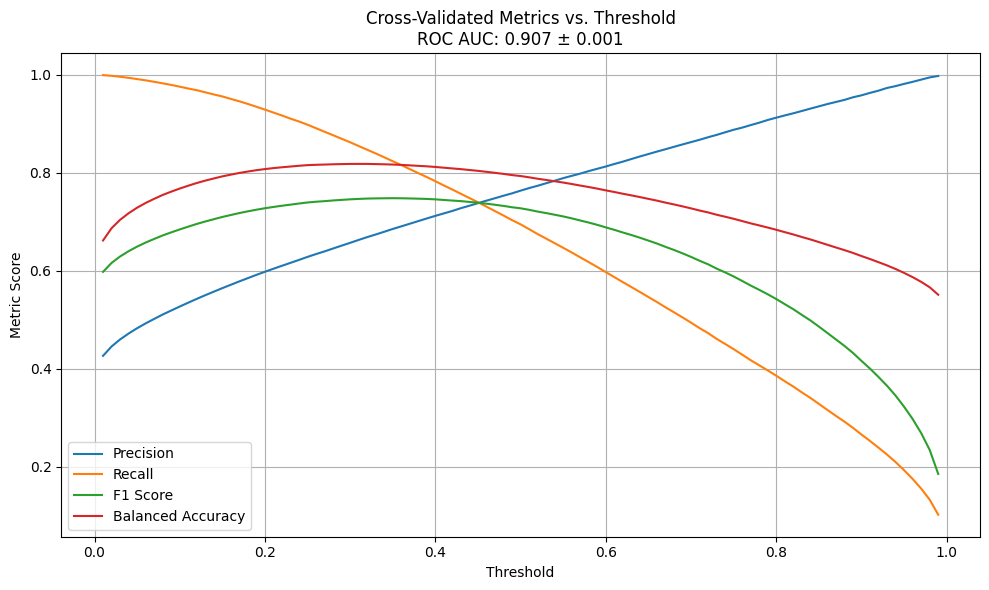

In [78]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
data = loop10_data
data_cols = [col for col in data.columns if 'COEFFICIENTS' not in col]
target_col = 'COEFFICIENTS'
X = data[data_cols].values
y = data[target_col].values.ravel()

# --- Thresholds ---
thresholds = np.linspace(0.01, 0.99, 99)
precisions = np.zeros_like(thresholds)
recalls = np.zeros_like(thresholds)
f1s = np.zeros_like(thresholds)
balanced_accuracies = np.zeros_like(thresholds)
splits = 3

# --- Track ROC AUC per fold
roc_aucs = []

# --- Stratified K-Fold CV ---
kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_test, X_train = X[train_idx], X[test_idx]
    y_test, y_train = y[train_idx], y[test_idx]

    # --- Scaling (fit on train only, transform both train/test) ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model training ---
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_scores)
    roc_aucs.append(auc)
    print(f"Fold {fold+1} ROC AUC: {auc:.3f}")

    for i, t in enumerate(thresholds):
        y_pred = (y_scores >= t).astype(int)
        precisions[i] += precision_score(y_test, y_pred, zero_division=0)
        recalls[i] += recall_score(y_test, y_pred)
        f1s[i] += f1_score(y_test, y_pred)
        balanced_accuracies[i] += balanced_accuracy_score(y_test, y_pred)

# --- Average metrics across folds ---
n_folds = kf.get_n_splits()
precisions /= n_folds
recalls /= n_folds
f1s /= n_folds
balanced_accuracies /= n_folds

# --- Report AUC ---
mean_auc = np.mean(roc_aucs)
std_auc = np.std(roc_aucs)
print(f"\nAverage ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.plot(thresholds, balanced_accuracies, label="Balanced Accuracy")

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Cross-Validated Metrics vs. Threshold\nROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
